#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [223]:
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [224]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {} # {class=0: {feature_index=0: {feature_value=0: 0.666, ... }, ... }, ... }

    def build_classifier(self, train_features, train_classes):
        class_counter = Counter(train_classes)
        self.priors = {key: class_items_number / len(train_classes) for key, class_items_number in class_counter.items()}
        train_features_discrete = self.data_discretization(train_features)
        data = np.column_stack((train_features_discrete, train_classes))  # entend train_features with train_classes
        sorted_indices = np.argsort(data[:, -1])  # sort by train_classes values
        data = data[sorted_indices]
        sorted_classes = sorted(class_counter.keys())
        first_iteration = True
        for _class in sorted_classes:
            self.likelihoods[_class] ={}
            if first_iteration:
                first_row = 0
                last_row = class_counter[_class]
                first_iteration = False
            else:
                first_row = last_row
                last_row = first_row + class_counter[_class]

            one_class_features = data[first_row:last_row, :-1]
            for column_index in range(one_class_features.shape[-1]):
                feature_counter = Counter(one_class_features[:,column_index])
                self.likelihoods[_class][column_index] = {key: feature_items_number / len(one_class_features) for key, feature_items_number in feature_counter.items()}



    def data_discretization(self, data, number_of_discrete_values=4):
        new_data = np.zeros_like(data, dtype='int32')
        self.discrete_boundaries = np.zeros([data.shape[-1], number_of_discrete_values-1])
        for column_index in range(data.shape[-1]):
            max_column_value = np.max(data[:,column_index])
            min_column_value = np.min(data[:,column_index])
            disrete_range = (max_column_value-min_column_value) * 1/number_of_discrete_values
            self.discrete_boundaries[column_index] = np.linspace(min_column_value, max_column_value, number_of_discrete_values+1)[1:-1]
            new_data[:, column_index] = np.digitize(data[:, column_index], self.discrete_boundaries[column_index], right=True).astype('int32')
        return new_data

    def sample_discretization(self, sample):
        return np.array([np.digitize(feature, self.discrete_boundaries[i], right=True).astype('int32') for i,feature in enumerate(sample)])

    def predict(self, sample):
        discrete_sample = self.sample_discretization(sample)
        class_probabilities = {}
        for _class in self.priors.keys():
            probability = self.priors[_class]
            for feature_index, feature_value in enumerate(discrete_sample):
                try:
                    probability *= self.likelihoods[_class][feature_index][feature_value]
                except KeyError:
                    probability *= 0
            class_probabilities[_class] = probability
        normalization_constant = sum(class_probabilities.values())
        if normalization_constant !=0:
            class_probabilities = {key: value / normalization_constant for key, value in class_probabilities.items()}
        return max(class_probabilities, key=class_probabilities.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {} # {class=0: {feature_index=0: [mean, std], ...}, ... }

    def build_classifier(self, train_features, train_classes):
        class_counter = Counter(train_classes)
        self.priors = {key: class_item_number / len(train_classes) for key, class_item_number in class_counter.items()}
        data = np.column_stack((train_features, train_classes))  # entend train_features with train_classes
        sorted_indices = np.argsort(data[:, -1])  # sort by train_classes values
        data = data[sorted_indices]
        sorted_classes = sorted(class_counter.keys())
        first_iteration = True
        for _class in sorted_classes:
            self.likelihoods[_class] ={}
            if first_iteration:
                first_row = 0
                last_row = class_counter[_class]
                first_iteration = False
            else:
                first_row = last_row
                last_row = first_row + class_counter[_class]

            one_class_features = data[first_row:last_row, :-1]
            for column_index in range(one_class_features.shape[-1]):
                mean = np.mean(one_class_features[:,column_index])
                # if E(X^2) - E(X)^2 < 0
                means_difference = np.mean(np.power(one_class_features[:,column_index],2)) - np.power(mean, 2)
                if means_difference >= 0:
                    std = np.sqrt(means_difference)
                else:
                    std = 0
                self.likelihoods[_class][column_index] = [mean, std]

    @staticmethod
    def normal_dist(x, mean, std):
        if std == 0:
            return 0
        else:
            return (1/(std*np.sqrt(2*np.pi))) * np.exp((-np.power(x-mean, 2))/(2*np.power(std, 2)))


    def predict(self, sample):
        class_probabilities = {}
        for _class in self.priors.keys():
            probability = self.priors[_class]
            likelihoods = self.likelihoods[_class]
            for feature_index, feature_value in enumerate(sample):
                mean, std = likelihoods[feature_index]
                probability *= self.normal_dist(feature_value, mean, std)
            class_probabilities[_class] = probability
        normalization_constant = sum(class_probabilities.values())
        if normalization_constant !=0:
            class_probabilities = {key: value / normalization_constant for key, value in class_probabilities.items()}
        return max(class_probabilities, key=class_probabilities.get)

In [225]:
def testNaiveBayesClassifier(data, is_guassian=False):
    x_train, x_test, y_train, y_test = data
    if is_guassian:
        classifier = GaussianNaiveBayes()
    else:
        classifier = NaiveBayes()
    classifier.build_classifier(x_train, y_train)
    successes = 0
    for i, sample in enumerate(x_test):
        y_prediction = classifier.predict(sample)
        if y_test[i] == y_prediction:
            successes += 1
    accuracy = successes/len(x_test)
    return accuracy

In [226]:
def plot_accuracies(x,y,is_guassian=False, random_state=123):
    test_size_range = [i/10 for i in range(1, 10)]
    accuracy_list = []
    for test_size in test_size_range:
        data = train_test_split(x, y, test_size=test_size, random_state=random_state)
        accuracy_list.append(testNaiveBayesClassifier(data, is_guassian))

    plt.xlabel('test size')
    plt.ylabel('Accuracy')
    if is_guassian:
        title = "Gaussian"
    else:
        title= ""
    plt.title(f'{title}NaiveBayesClassifier \n Accuracy depending on test_size \n random_state={random_state}')

    plt.plot(test_size_range, accuracy_list)
    plt.show()

# Zbiór Iris (dane ciągłe)

## NaiveBayes tests

In [227]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data
y = iris.target

In [228]:
print(f'Accuracy - NaiveBayes (testsize=0.1, random_state=123) = {testNaiveBayesClassifier(train_test_split(x, y, test_size=0.1, random_state=123))}')

Accuracy - NaiveBayes (testsize=0.1, random_state=123) = 0.9333333333333333


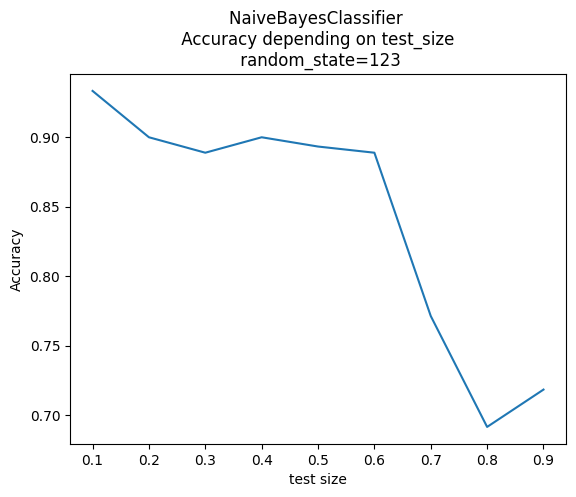

In [229]:
plot_accuracies(x,y)

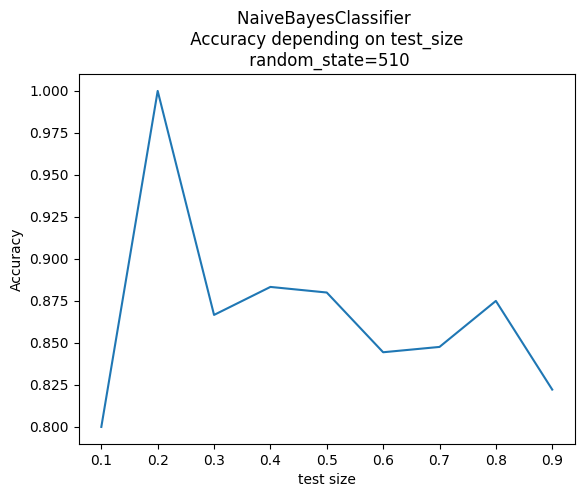

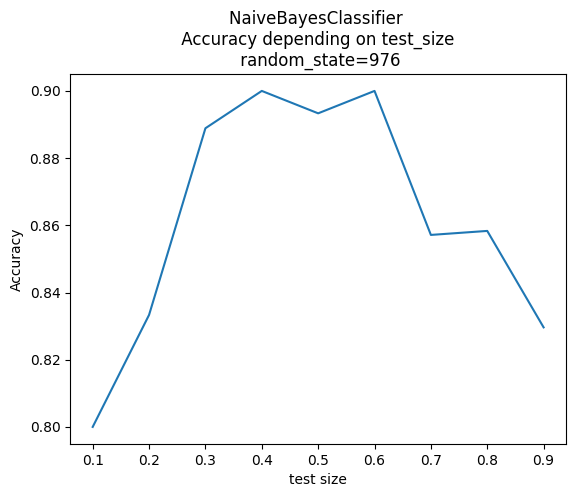

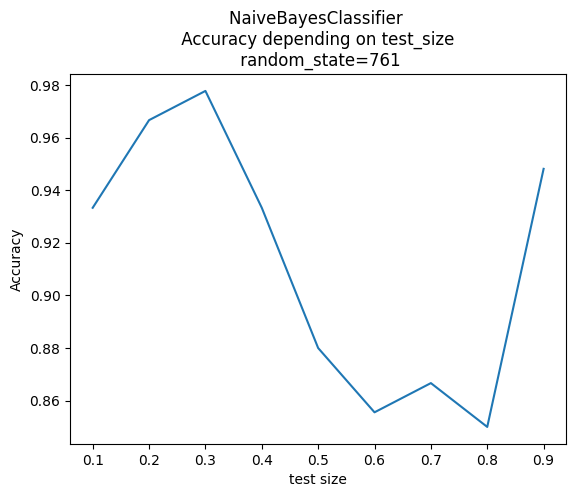

In [230]:
for random_state in np.random.randint(0, 1000, size=3):
    plot_accuracies(x, y, random_state=random_state)
    print()

# GaussianNaiveBayes tests

In [231]:
print(f'Accuracy - GaussianNaiveBayes (testsize=0.1, random_state=123) = {testNaiveBayesClassifier(train_test_split(x, y, test_size=0.1, random_state=123), True)}')

Accuracy - GaussianNaiveBayes (testsize=0.1, random_state=123) = 1.0


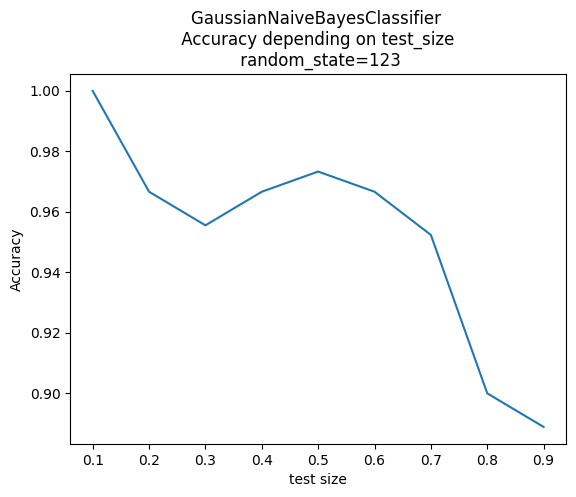

In [232]:
plot_accuracies(x,y,True)

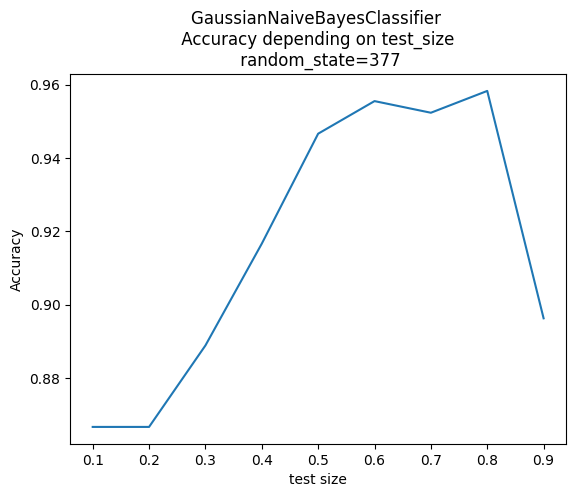

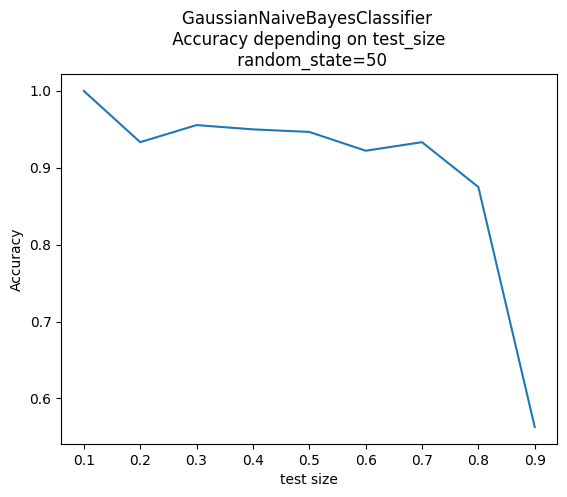

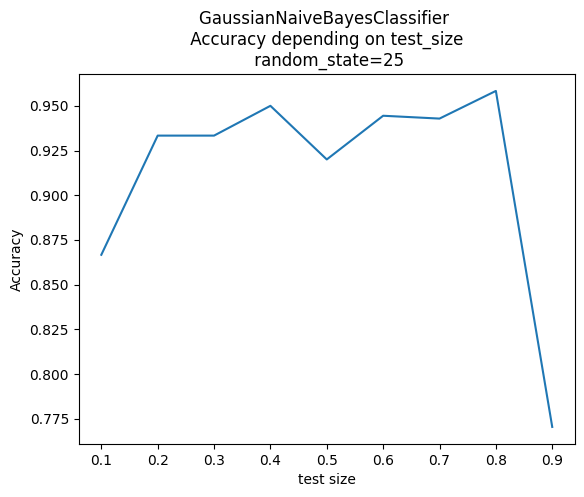

In [233]:
for random_state in np.random.randint(0, 1000, size=3):
    plot_accuracies(x,y,True, random_state)
    print()

# Zbiór Digits (dane dyskretne)

In [234]:
from sklearn.datasets import load_digits
digits = load_digits()
x = digits.data
y = digits.target
print(f'Accuracy - NaiveBayes (testsize=0.1, random_state=123) = {testNaiveBayesClassifier(train_test_split(x, y, test_size=0.1, random_state=123))}')
print(f'Accuracy - GaussianNaiveBayes (testsize=0.1, random_state=123) = {testNaiveBayesClassifier(train_test_split(x, y, test_size=0.1, random_state=123), True)}')

Accuracy - NaiveBayes (testsize=0.1, random_state=123) = 0.8833333333333333
Accuracy - GaussianNaiveBayes (testsize=0.1, random_state=123) = 0.07222222222222222


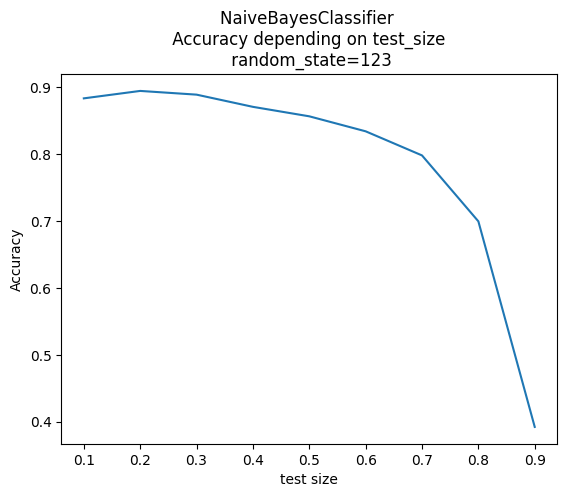

In [235]:
plot_accuracies(x,y)

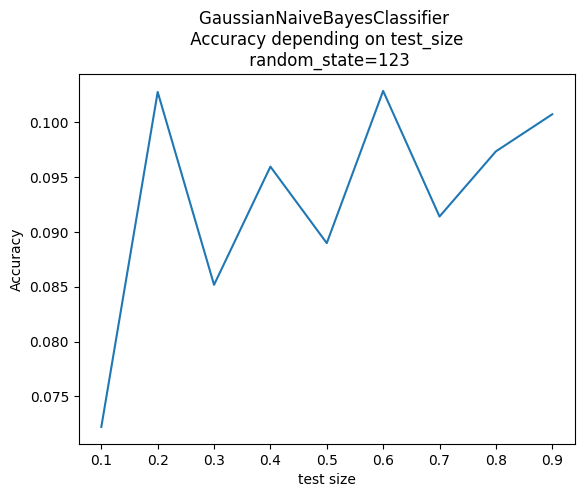

In [236]:
plot_accuracies(x,y, True)

# Wnioski
Udało się poprawnie zaimplementować oba klasyfikatory.
Klasyfikatory różnią się znacząco przeznaczeniem. W przypadku, gdy mamy cechy o rozkładzie ciągłym tak jak np. w datasecie iris, lepiej sprawdzi się oczywiście klasyfikator korzystający z rozkładu normalnego, ponieważ podobne cechy będą dawały podobne prawdopodobieństwa.
W przypadku datasetów, które mają dyskretny charakter cech, tak jak np. w przypadku digits (cechy to piksele, 0 lub 1) znacznie lepiej sprawdza się klasyfikator dyskretny, tutaj rozkład normalny nic by nam nie dał, ponieważ interesują nas prawdopodobieństwa dla konkretnych wartości cech.
